# 2장. 간단한 분류 알고리즘 훈련

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch02/ch02.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch02/ch02.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [ ]:
#!pip install watermark

In [1]:
%load_ext watermark
%watermark -u -d -p numpy,pandas,matplotlib

last updated: 2019-04-25 

numpy 1.16.3
pandas 0.24.2
matplotlib 3.0.3


# 파이썬으로 퍼셉트론 학습 알고리즘 구현하기

## 객체 지향 퍼셉트론 API

In [5]:
import numpy as np


class Perceptron(object):
    """퍼셉트론 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    errors_ : list
      에포크마다 누적된 분류 오류

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [3]:
v1 = np.array([1, 2, 3])
v2 = 0.5 * v1
np.arccos(v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

0.0

## 붓꽃 데이터셋에서 퍼셉트론 훈련하기

### 붓꽃 데이터셋 읽기

In [2]:
import pandas as pd

df = pd.read_csv('./iris.data', header=None)
df

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### 노트:

이 깃허브에는 붓꽃 데이터셋이 포함되어 있습니다(이 책에서 사용하는 다른 데이터셋도 모두 포함되어 있습니다). 인터넷에 연결되어 있지 않거나 이따금 UCI 서버(https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)에 접근할 수 없을 때 사용할 수 있습니다. 이런 경우 로컬 디렉터리에서 붓꽃 데이터를 로드하려면 다음 코드를
```python
    df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
```
다음과 같이 바꿉니다.
```python 
    df = pd.read_csv('your/local/path/to/iris.data', header=None)
```

### 붓꽃 데이터 그래프 그리기

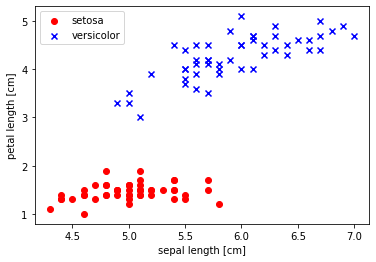

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# setosa와 versicolor를 선택합니다
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# 꽃받침 길이와 꽃잎 길이를 추출합니다
X = df.iloc[0:100, [0, 2]].values

# 산점도를 그립니다
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

### 퍼셉트론 모델 훈련하기

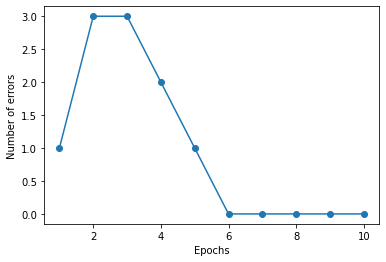

In [6]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of errors')

plt.show()

### 결정 경계 그래프 함수

In [7]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

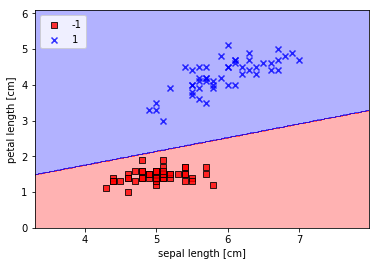

In [8]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

# 적응형 선형 뉴런과 학습의 수렴

## 파이썬으로 아달린 구현하기

In [9]:
class AdalineGD(object):
    """적응형 선형 뉴런 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

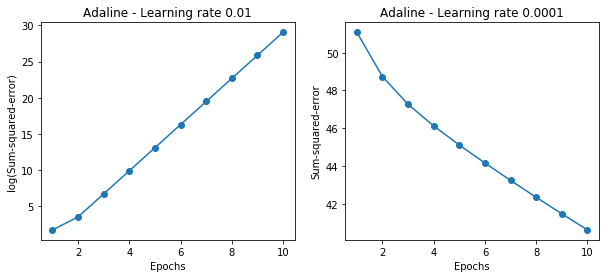

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

## 특성 스케일을 조정하여 경사 하강법 결과 향상시키기

In [11]:
# 특성을 표준화합니다.
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

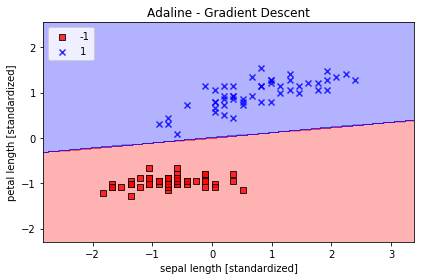

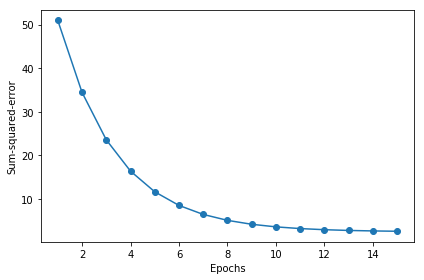

In [12]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.show()

## 대규모 머신 러닝과 확률적 경사 하강법

In [13]:
class AdalineSGD(object):
    """ADAptive LInear NEuron 분류기

    Parameters
    ------------
    eta : float
                           학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    shuffle : bool (default: True)
      True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞습니다
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    Attributes
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      모든 훈련 샘플에 대해 에포크마다 누적된 평균 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """훈련 데이터 학습

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃 벡터

        반환값
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """가중치를 다시 초기화하지 않고 훈련 데이터를 학습합니다"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """훈련 데이터를 섞습니다"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """랜덤한 작은 수로 가중치를 초기화합니다"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """아달린 학습 규칙을 적용하여 가중치를 업데이트합니다"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

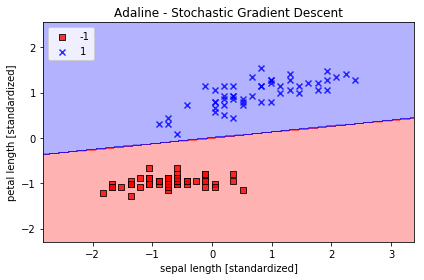

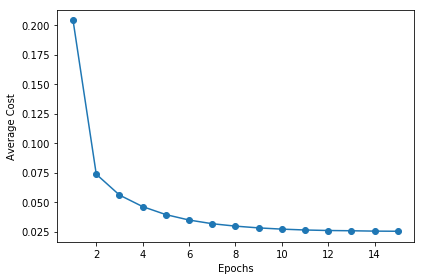

In [14]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()